In [1]:
#######################################################
#Import packages
import numpy as np
import os
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#ML Stuff
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics, svm
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# Feature selection
from sklearn import feature_selection
from sklearn.feature_selection import RFE
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#######################################################

In [2]:
os.listdir()

['iWellness3.0.txt',
 'Weight_Violin.png',
 'Wellness.ipynb',
 '.ipynb_checkpoints']

In [3]:
txt=open('iWellness3.0.txt','r').read().split('Grier\n')

In [4]:
# Drop name
usrdate=txt[0].split(',')[1:]
gender=usrdate[0].split(':')[1]

In [5]:
# Year, Month, Day
birth=[int(i) for i in usrdate[1].replace('Birthday','').strip().split('-')]
birth_year=birth[0]
birth_month=birth[1]
birth_date=birth[2]

In [6]:
from datetime import date 
  
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 
    return age

In [7]:
age=calculateAge(date(birth_year,birth_month,birth_date))

In [8]:
# Dates of weighins 
dates=[i.split('\n')[:-3][0].split(',')[-1].strip() for i in txt[1:]]

# In lbs
weight=[float(i.split('\n')[:-3][1].replace('Weight','').replace('lb','').strip()) for i in txt[1:]]

# Body water %
body_water=[float(i.split('\n')[:-3][2].replace('Body Water  ','').replace('%','')) for i in txt[1:]]

# Body Fat %
body_Fat=[float(i.split('\n')[:-3][3].replace('Body Fat  ','').replace('%','')) for i in txt[1:]]

# Bone Mas
bone_mass=[float(i.split('\n')[:-3][4].replace('Bone Mass  ','').replace('lb','').strip()) for i in txt[1:]]

# BMI
BMI=[float(i.split('\n')[:-3][5].replace('BMI  ','')) for i in txt[1:]]

# visceral fat
visceral_fat=[float(i.split('\n')[:-3][6].replace('Visceral Fat  ','')) for i in txt[1:]]

# BMR=Basal Metabolic Rate
BMR=[float(i.split('\n')[:-3][7].replace('BMR  ','').replace('Kcal','')) for i in txt[1:]]

# Muscle mass
muscle_mass=[float(i.split('\n')[:-3][8].replace('Muscle Mass  ','').replace('lb','')) for i in txt[1:]]

In [9]:
X=pd.DataFrame({'age':age,'body_water':body_water,'body_Fat':body_Fat,'bone_mass':bone_mass,'BMI':BMI,'visceral_fat':visceral_fat,'BMR':visceral_fat,'muscle_mass':muscle_mass},index=dates).iloc[::-1]
y=pd.DataFrame({'weight':weight},index=dates).iloc[::-1]

In [18]:
# y.to_excel('Weights.xlsx')

In [19]:
y.describe()

weight
count   20.000000
mean   268.520000
std      1.778704
min    266.000000
25%    267.200000
50%    268.400000
75%    268.950000
max    272.200000

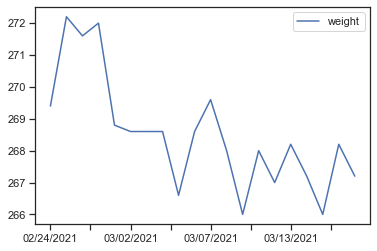

In [10]:
y.plot()

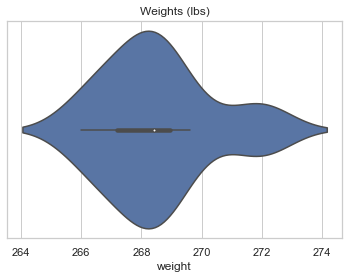

In [11]:
sns.set_style(style='whitegrid')
ax = sns.violinplot(x=y['weight'], )
plt.title('Weights (lbs)')
plt.savefig('Weight_Violin.png',dpi=800)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [13]:
scaler1 = MinMaxScaler().fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)


In [14]:
len(y_train),len(y_test),len(y_train)+len(y_test)

(14, 6, 20)

In [15]:

reg8 = KernelRidge(alpha=1e-3,gamma=1e-3,kernel='laplacian')
reg8.fit(X_train_scaled,y_train)

y_test_pred=reg8.predict(X_test_scaled)
y_train_pred=reg8.predict(X_train_scaled)




print('Training score %0.4f'%reg8.score(X_train_scaled,y_train))
print('Test score %0.4f'%reg8.score(X_test_scaled,y_test))
print('Test MAE: %.4E' % (mean_absolute_error(y_test, y_test_pred)), 'kcal/mol')
print('Test RMSE: %.4E' % (np.sqrt(mean_squared_error(y_test, y_test_pred))), 'kcal/mol','\n')

Training score 0.9549
Test score 0.8237
Test MAE: 4.1693E-01 kcal/mol
Test RMSE: 5.1009E-01 kcal/mol 



Train R2 0.9548663652327285
Train MAE: 3.4036E-01 kcal/mol
Train RMSE: 3.9622E-01 kcal/mol 

Test R2 0.8236673899015615
Test MAE: 4.1693E-01 kcal/mol
Test RMSE: 5.1009E-01 kcal/mol 



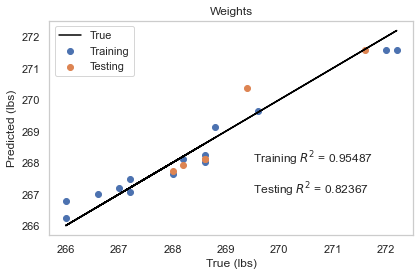

In [16]:
from sklearn.metrics import r2_score
print('Train R2',r2_score(y_train, reg8.predict(X_train_scaled)))
print('Train MAE: %.4E' % (mean_absolute_error(y_train, reg8.predict(X_train_scaled))), 'kcal/mol')
print('Train RMSE: %.4E' % (np.sqrt(mean_squared_error(y_train, reg8.predict(X_train_scaled)))), 'kcal/mol','\n')

print('Test R2',r2_score(y_test, reg8.predict(X_test_scaled)))
print('Test MAE: %.4E' % (mean_absolute_error(y_test, reg8.predict(X_test_scaled))), 'kcal/mol')
print('Test RMSE: %.4E' % (np.sqrt(mean_squared_error(y_test, reg8.predict(X_test_scaled)))), 'kcal/mol','\n')
plt.scatter(y_train, reg8.predict(X_train_scaled),label='Training')
plt.scatter(y_test, reg8.predict(X_test_scaled),label='Testing')
plt.plot(y_train, y_train,label='True',color='black')

plt.xlabel('True (lbs)')
plt.ylabel('Predicted (lbs)')
plt.legend()
xspot=max(y_train)
yspot=max(y_train)
# print(xspot, yspot)
plt.text(269.5,268,'Training $R^{2}$ = %0.5f' % r2_score(y_train, reg8.predict(X_train_scaled)),bbox=dict(facecolor='white', alpha=0.75))
plt.text(269.5,267,'Testing $R^{2}$ = %0.5f' % r2_score(y_test, reg8.predict(X_test_scaled)),bbox=dict(facecolor='white', alpha=0.75))
plt.title('Weights')
plt.grid(False)
plt.tight_layout()
# plt.savefig('regression_plot.png',dpi=800)
plt.show()